In [1]:
# # !pip install torchtext

# import torch
# print(torch.__version__)

In [2]:
# !pip install --upgrade git+https://github.com/pytorch/pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext import data
from torchtext.data import Field
from torchtext.data import BucketIterator


import spacy
import numpy as np
import os
import random
import pandas as pd
import time
import math

from sklearn.model_selection import train_test_split

# f = open("demofile2.txt", "a")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
# !wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py


In [4]:
!pip3 install datasets
from datasets import list_datasets, load_dataset, list_metrics, load_metric
dataset = load_dataset("cnn_dailymail", '3.0.0')
train=dataset['train']
test=dataset['test']
validate=dataset['validation']

     |████████████████████████████████| 153kB 943kB/s 
     |████████████████████████████████| 17.7MB 1.4MB/s 
     |████████████████████████████████| 245kB 53.8MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602. Subsequent calls will reuse this data.


In [5]:
# !pip install torch==1.6 torchtext==0.7
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
stories_train = []
summaries_train = []

stories_test = []
summaries_test = []

stories_validate = []
summaries_validate = []

num = 10
for i in range(len(train)):
    story = train[i]['article']
    summary = train[i]['highlights']
    stories_train.append(story)
    summaries_train.append(summary)
    # if i == num:
    #   break
for i in range(len(test)):
    story = test[i]['article']
    summary = test[i]['highlights']
    stories_test.append(story)
    summaries_test.append(summary)
    # if i == num:
    #   break
for i in range(len(validate)):
    story = validate[i]['article']
    summary = validate[i]['highlights']
    stories_validate.append(story)
    summaries_validate.append(summary)
    # if i == num:
    #   break
      
DATA_TRAIN = {"story": [story for story in stories_train], "summary": [summary for summary in summaries_train]}
DATA_TEST = {"story": [story for story in stories_test], "summary": [summary for summary in summaries_test]}
DATA_VALIDATE = {"story": [story for story in stories_validate], "summary": [summary for summary in summaries_validate]}

In [8]:
df_train = pd.DataFrame(DATA_TRAIN, columns=["story", "summary"])
df_test = pd.DataFrame(DATA_TEST, columns=["story", "summary"])
df_validate = pd.DataFrame(DATA_VALIDATE, columns=["story", "summary"])

df_train.to_json("train_data.json", orient="records", lines=True)
df_test.to_json("test_data.json", orient="records", lines=True)
df_validate.to_json("validation_data.json", orient="records", lines=True)

In [9]:
spacy_en = spacy.load('en')
MAX_LENGTH = 400

def tokenize(text):
    tokens = spacy_en.tokenizer(text)
    length = len(tokens)
    
    cnt = 0
    toRet = []
    
    for tok in tokens:
        if cnt < length and cnt < MAX_LENGTH:
            toRet.append(tok.text)
            cnt += 1
        
        else:
            break
    
    return toRet
#     return [tok.text for tok in spacy_en.tokenizer(text)]



In [10]:
story_field = Field(tokenize = tokenize, init_token = '<sos>', eos_token = '<eos>', lower = True, include_lengths = True)
summary_field = Field(tokenize =tokenize, init_token = '<sos>', eos_token = '<eos>', lower = True)
fields = {'story': ('story', story_field), 'summary': ('summary', summary_field)}


In [11]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

In [29]:
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.story),
     device = device)


In [14]:
story_field.build_vocab(train_data, min_freq = 2)
summary_field.build_vocab(train_data, min_freq = 2)

print(len(story_field.vocab))
print(len(summary_field.vocab))

137
68


In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [20]:
INPUT_DIM = len(story_field.vocab)
OUTPUT_DIM = len(summary_field.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = story_field.vocab.stoi[story_field.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(137, 5)
    (rnn): GRU(5, 5, bidirectional=True)
    (fc): Linear(in_features=10, out_features=5, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=15, out_features=5, bias=True)
      (v): Linear(in_features=5, out_features=1, bias=False)
    )
    (embedding): Embedding(68, 5)
    (rnn): GRU(15, 5)
    (fc_out): Linear(in_features=20, out_features=68, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,283 trainable parameters


In [23]:
optimizer = optim.Adam(model.parameters())


In [24]:
TRG_PAD_IDX = summary_field.vocab.stoi[summary_field.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.story
        trg = batch.summary
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.story
            trg = batch.summary

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 0s
	Train Loss: 4.220 | Train PPL:  68.003
	 Val. Loss: 4.218 |  Val. PPL:  67.888


In [31]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.218 | Test PPL:  67.895 |


In [62]:
def make_summary(sentence, src_field, trg_field, model, device, max_len = 100):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [44]:
# def display_attention(article, summary, attention):
    
#     fig = plt.figure(figsize=(100,100))
#     ax = fig.add_subplot(111)
    
#     attention = attention.squeeze(1).cpu().detach().numpy()
    
#     cax = ax.matshow(attention, cmap='bone')
   
#     ax.tick_params(labelsize=15)
#     ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in article]+['<eos>'], 
#                        rotation=45)
#     ax.set_yticklabels(['']+summary)

#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()
#     plt.close()

In [39]:
example_idx = 2

src = vars(train_data.examples[example_idx])['story']
trg = vars(train_data.examples[example_idx])['summary']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['kansas', 'city', ',', 'missouri', '(', 'cnn', ')', '--', 'the', 'general', 'services', 'administration', ',', 'already', 'under', 'investigation', 'for', 'lavish', 'spending', ',', 'allowed', 'an', 'employee', 'to', 'telecommute', 'from', 'hawaii', 'even', 'though', 'he', 'is', 'based', 'at', 'the', 'gsa', "'s", 'kansas', 'city', ',', 'missouri', ',', 'office', ',', 'a', 'cnn', 'investigation', 'has', 'found', '.', 'it', 'cost', 'more', 'than', '$', '24,000', 'for', 'the', 'business', 'development', 'specialist', 'to', 'travel', 'to', 'and', 'from', 'the', 'mainland', 'united', 'states', 'over', 'the', 'past', 'year', '.', 'he', 'is', 'among', 'several', 'hundred', 'gsa', '"', 'virtual', '"', 'workers', 'who', 'also', 'travel', 'to', 'various', 'conferences', 'and', 'their', 'home', 'offices', ',', 'costing', 'the', 'agency', 'millions', 'of']
trg = ['the', 'employee', 'in', 'agency', "'s", 'kansas', 'city', 'office', 'is', 'among', 'hundreds', 'of', '"', 'virtual', '"', 'worke

In [40]:
summary, attention = make_summary(src, story_field, summary_field, model, device)

print(f'predicted trg = {summary}')

predicted trg = ['\n', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']


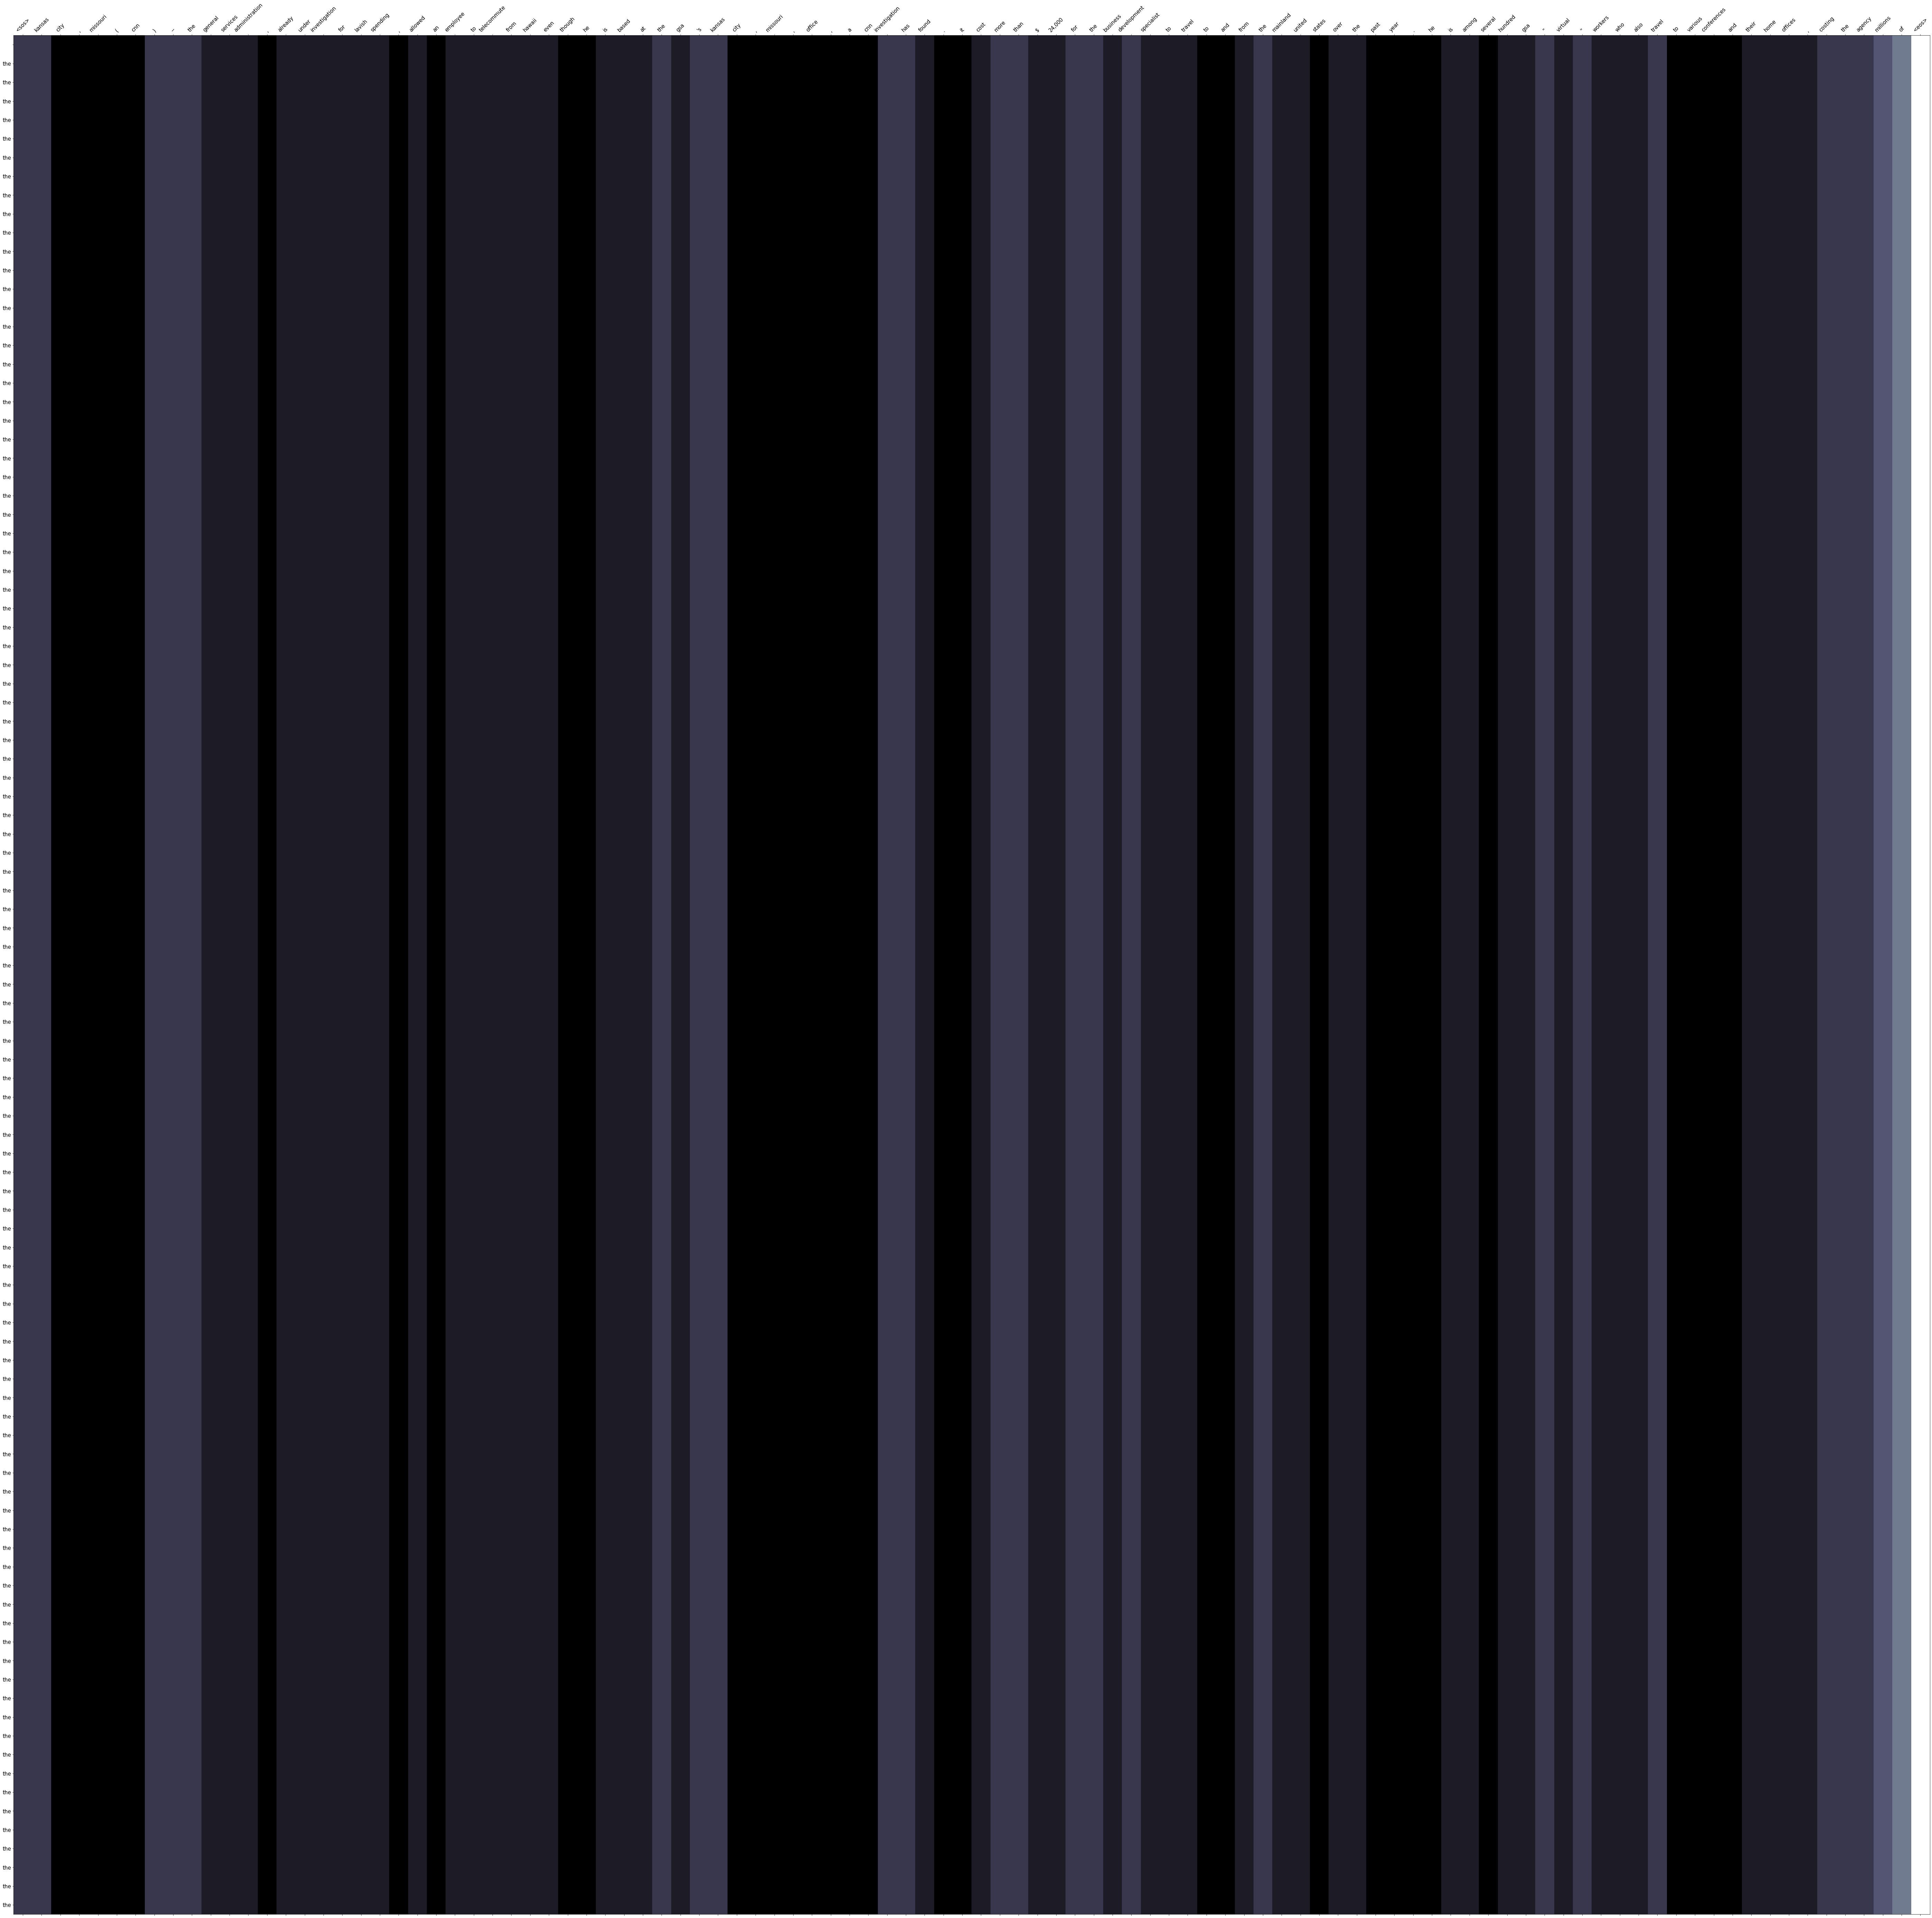

In [45]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# display_attention(src, summary, attention)

In [48]:
example_idx = 1

src = vars(validation_data.examples[example_idx])['story']
trg = vars(validation_data.examples[example_idx])['summary']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['(', 'cnn)sigma', 'alpha', 'epsilon', 'is', 'under', 'fire', 'for', 'a', 'video', 'showing', 'party', '-', 'bound', 'fraternity', 'members', 'singing', 'a', 'racist', 'chant', '.', 'sae', "'s", 'national', 'chapter', 'suspended', 'the', 'students', ',', 'but', 'university', 'of', 'oklahoma', 'president', 'david', 'boren', 'took', 'it', 'a', 'step', 'further', ',', 'saying', 'the', 'university', "'s", 'affiliation', 'with', 'the', 'fraternity', 'is', 'permanently', 'done', '.', 'the', 'news', 'is', 'shocking', ',', 'but', 'it', "'s", 'not', 'the', 'first', 'time', 'sae', 'has', 'faced', 'controversy', '.', 'sae', 'was', 'founded', 'march', '9', ',', '1856', ',', 'at', 'the', 'university', 'of', 'alabama', ',', 'five', 'years', 'before', 'the', 'american', 'civil', 'war', ',', 'according', 'to', 'the', 'fraternity', 'website', '.', 'when']
trg = ['sigma', 'alpha', 'epsilon', 'is', 'being', 'tossed', 'out', 'by', 'the', 'university', 'of', 'oklahoma', '.', '\n', 'it', "'s", 'also',

predicted trg = ['\n', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']


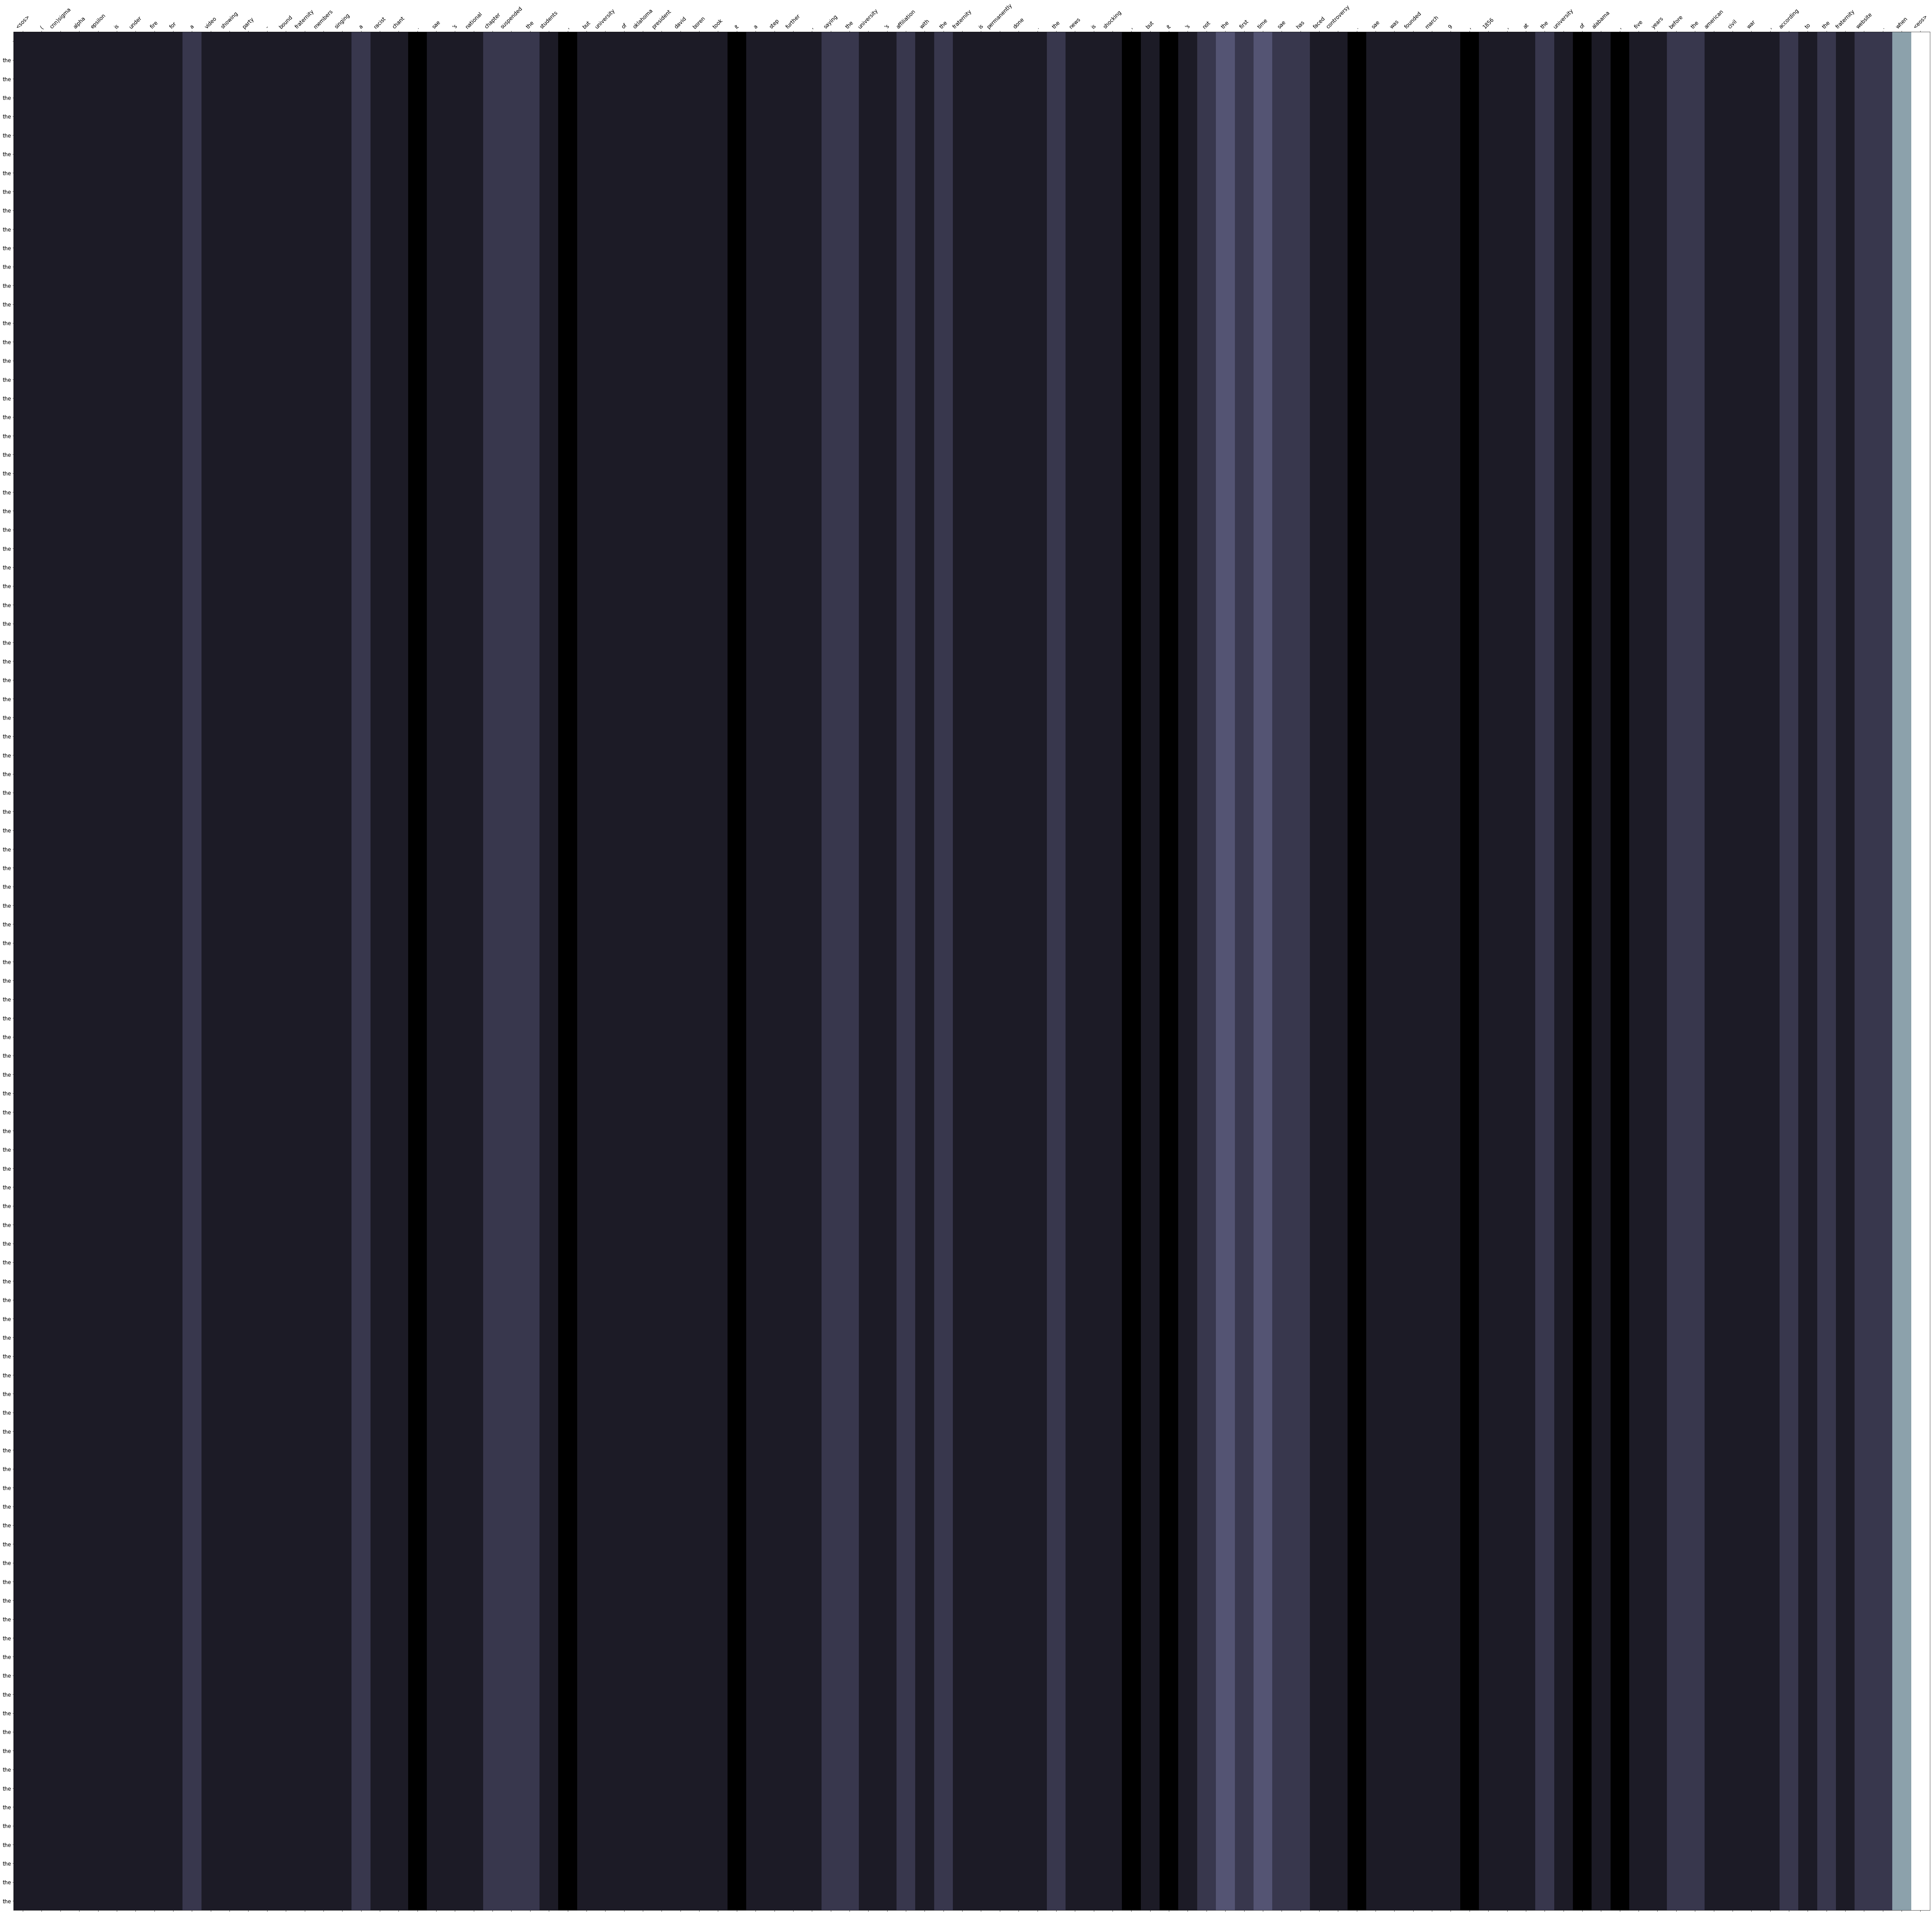

In [49]:
summary, attention = make_summary(src, story_field, summary_field, model, device)

print(f'predicted trg = {summary}')

# display_attention(src, summary, attention)

In [51]:
example_idx = 1

src = vars(test_data.examples[example_idx])['story']
trg = vars(test_data.examples[example_idx])['summary']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['(', 'cnn)the', 'attorney', 'for', 'a', 'suburban', 'new', 'york', 'cardiologist', 'charged', 'in', 'what', 'authorities', 'say', 'was', 'a', 'failed', 'scheme', 'to', 'have', 'another', 'physician', 'hurt', 'or', 'killed', 'is', 'calling', 'the', 'allegations', 'against', 'his', 'client', '"', 'completely', 'unsubstantiated', '.', '"', 'appearing', 'saturday', 'morning', 'on', 'cnn', "'s", '"', 'new', 'day', ',', '"', 'randy', 'zelin', 'defended', 'his', 'client', ',', 'dr.', 'anthony', 'moschetto', ',', 'who', 'faces', 'criminal', 'solicitation', ',', 'conspiracy', ',', 'burglary', ',', 'arson', ',', 'criminal', 'prescription', 'sale', 'and', 'weapons', 'charges', 'in', 'connection', 'to', 'what', 'prosecutors', 'called', 'a', 'plot', 'to', 'take', 'out', 'a', 'rival', 'doctor', 'on', 'long', 'island', '.', '"', 'none', 'of', 'anything', 'in', 'this', 'case']
trg = ['a', 'lawyer', 'for', 'dr.', 'anthony', 'moschetto', 'says', 'the', 'charges', 'against', 'him', 'are', 'baseles

predicted trg = ['\n', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']


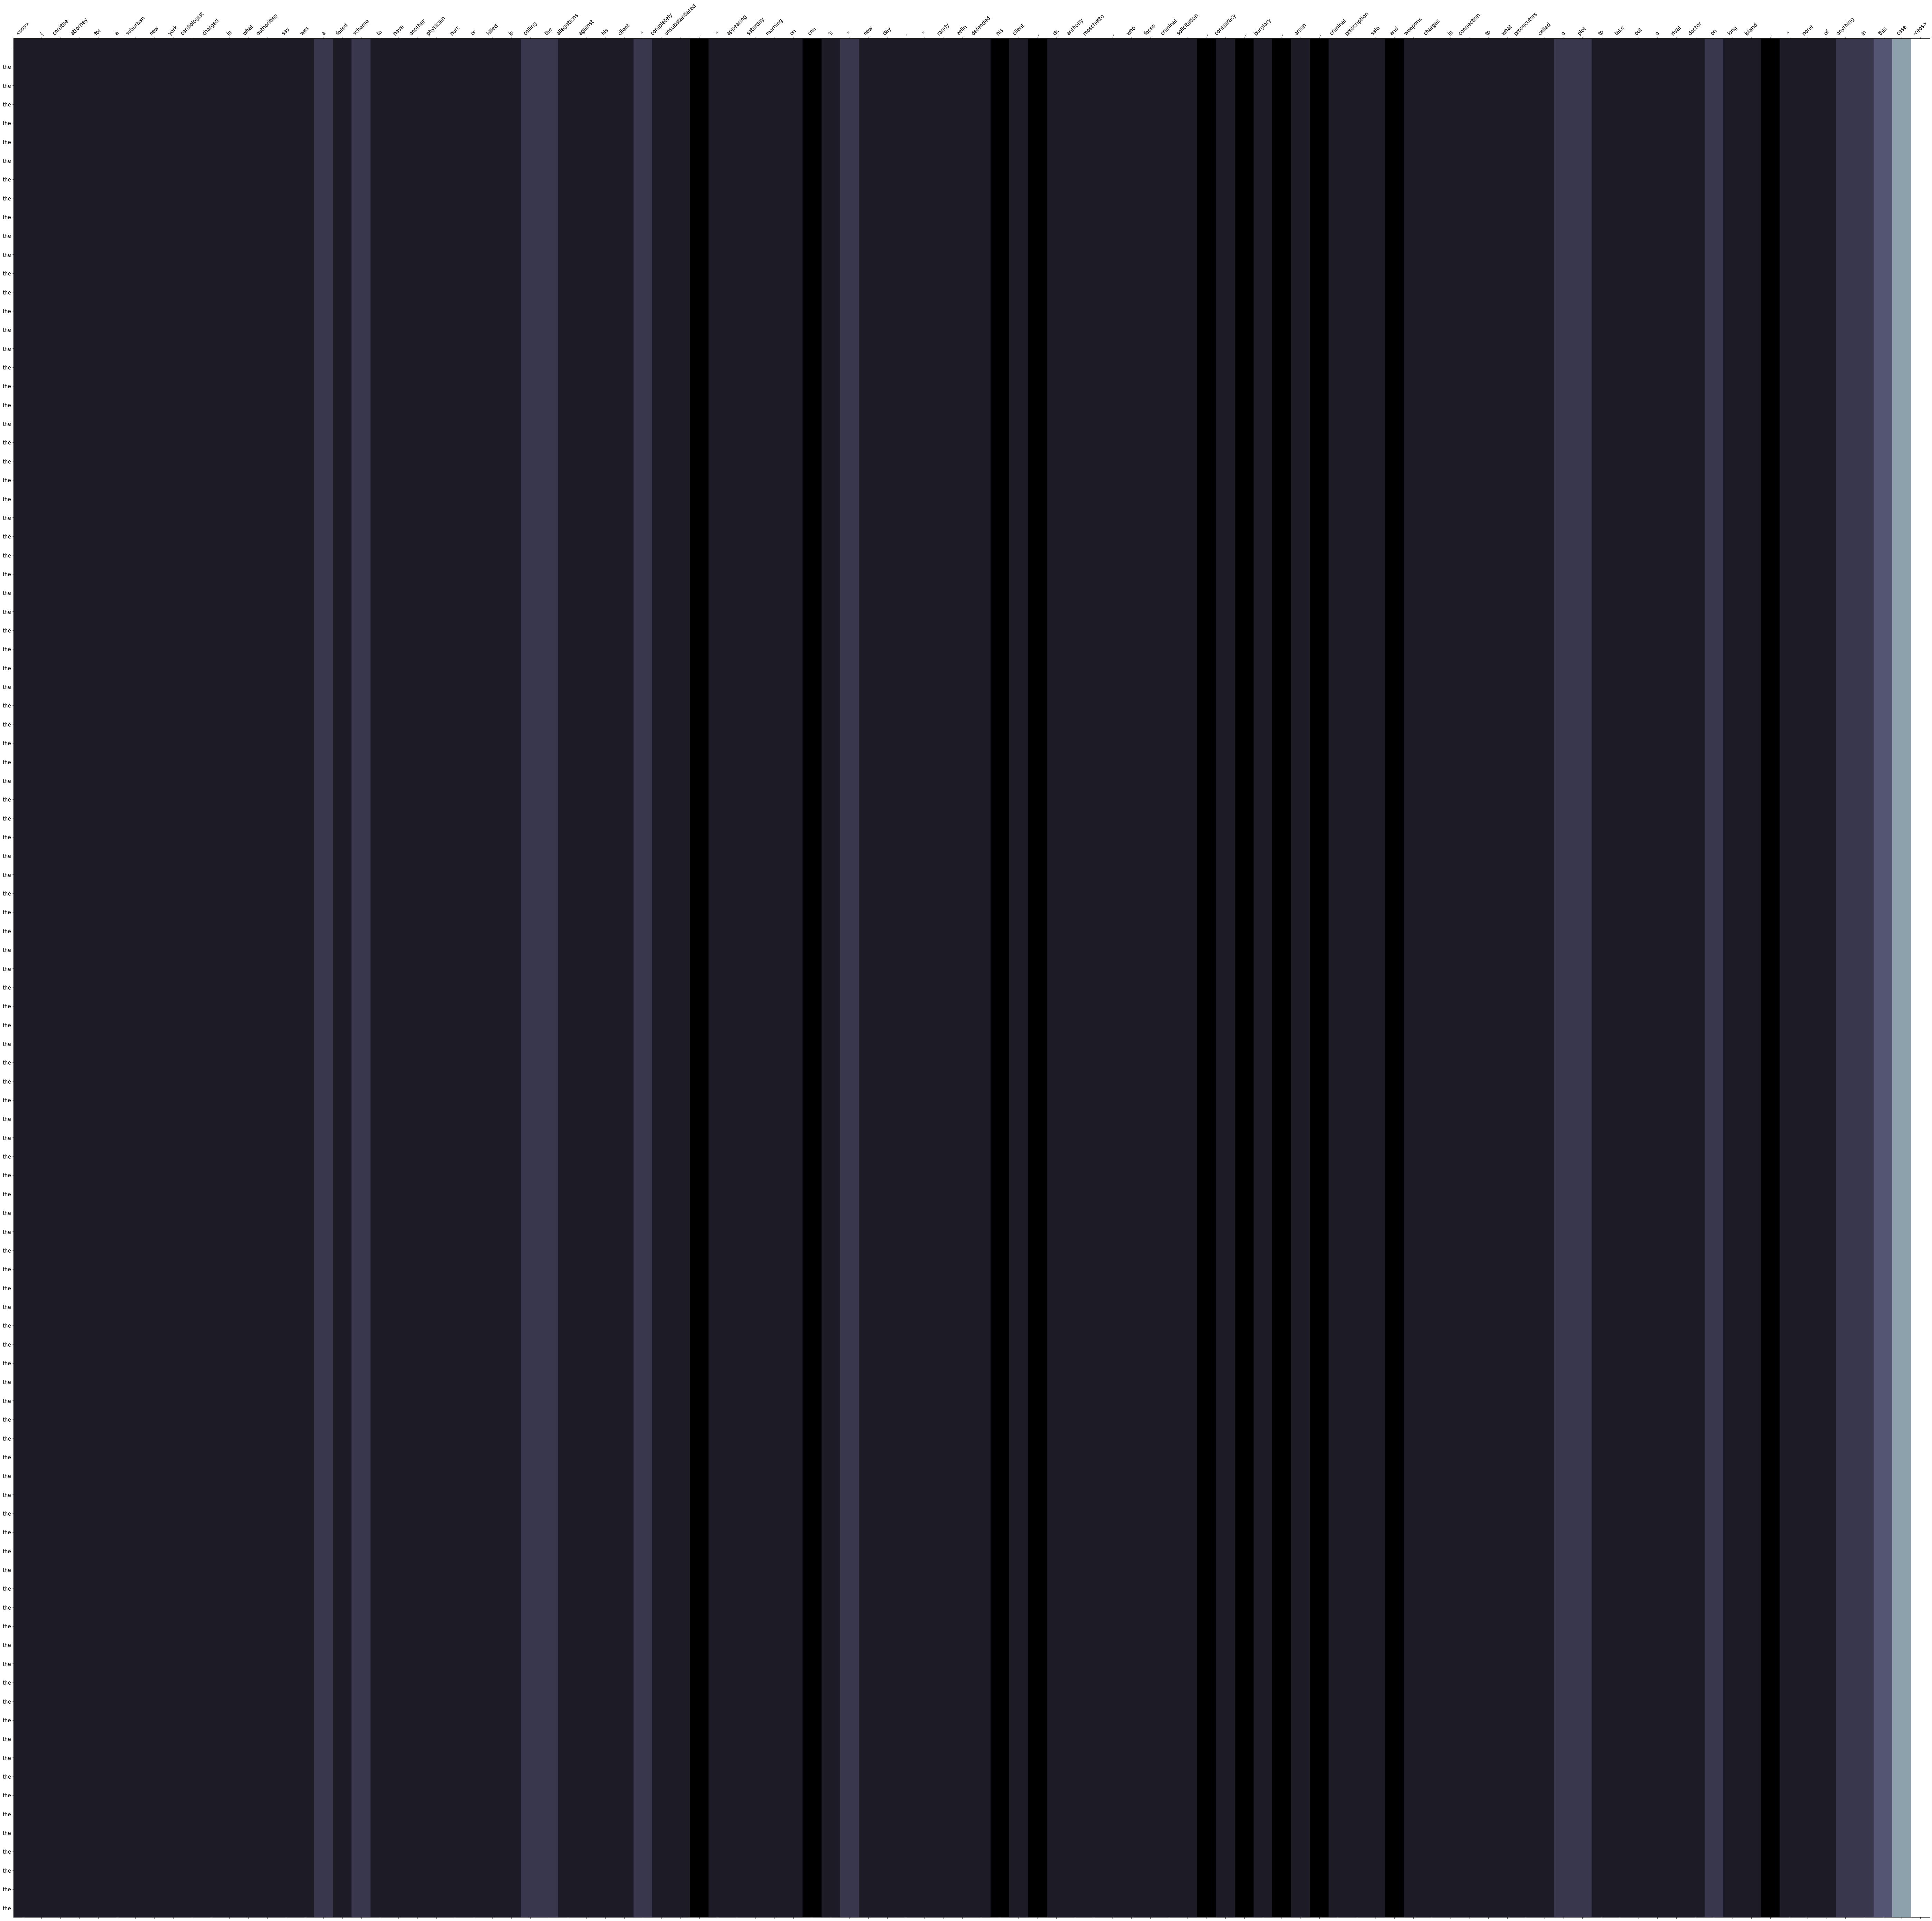

In [52]:


summary, attention = make_summary(src, story_field, summary_field, model, device)

print(f'predicted trg = {summary}')

# display_attention(src, summary, attention)

In [72]:
# !pip3 install pyrouge --upgrade
# !pip3 install https://github.com/bheinzerling/pyrouge/archive/master.zip
# !pip3 install pyrouge
# !pip3 show pyrouge
# !git clone https://github.com/andersjo/pyrouge.git
# from pyrouge import Rouge155
# !pyrouge_set_rouge_path 'pyrouge/tools/ROUGE-1.5.5'


Requirement already up-to-date: pyrouge in /usr/local/lib/python3.6/dist-packages (0.1.3)
  Using cached https://github.com/bheinzerling/pyrouge/archive/master.zip
  Created wheel for pyrouge: filename=pyrouge-0.1.3-cp36-none-any.whl size=191914 sha256=33872c8ae6e7deb626698da35fb7da5a3733c87d3334826a379f7e4858839d0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pwa1q1_4/wheels/70/02/b4/a23b5feb5980a5eb940441cb04ec1e17d5f18344138efbecf8
Successfully built pyrouge
Name: pyrouge
Version: 0.1.3
Summary: A Python wrapper for the ROUGE summarization evaluation package.
Home-page: https://github.com/noutenki/pyrouge
Author: Benjamin Heinzerling, Anders Johannsen
Author-email: benjamin.heinzerling@h-its.org
License: LICENSE.txt
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: 
fatal: destination path 'pyrouge' already exists and is not an empty directory.
2020-10-24 19:55:56,692 [MainThread  ] [INFO ]  Set ROUGE home directory to pyrouge/tools/ROUGE-1.5.5.


In [81]:
# r = Rouge155()
# # !mkdir ./predicted
# # !mkdir ./target
# r.system_dir = './predicted/'
# r.model_dir = './target'
# r.system_filename_pattern = 'file.(\d+).txt'
# r.model_filename_pattern = 'file.#ID#.txt'

In [94]:
def make_html_safe(s):
  s.replace("<", "&lt;")
  s.replace(">", "&gt;")
  return s

In [95]:
def store_data(data, src_field, trg_field, model, device, max_len = 100):
    
    trgs = []
    pred_trgs = []
    idx = 1
    for datum in data:
        
        src = vars(datum)['story']
        trg = vars(datum)['summary']
        
        src = ' '.join(src)
        trg = ' '.join(trg)
        pred_trg, _ = make_summary(src, src_field, trg_field, model, device, max_len)
        pred_trg = pred_trg[:-1]
        pred_trg = ' '.join(pred_trg)

        trg = trg.replace("\n", "")
        pred_trg = pred_trg.replace("\n", "")
        trg = trg.split(".")
        pred_trg = pred_trg.split(".")

        trg = "\n".join(trg)
        pred_trg = "\n".join(pred_trg)
        trg = make_html_safe(trg)
        pred_trg = make_html_safe(pred_trg)

        pred_file = open("./predicted/file." + str(idx) + ".txt", "w+")
        trg_file = open("./target/file." + str(idx) +".txt", "w+")

        pred_file.write(pred_trg)
        trg_file.write(trg)
        pred_file.close()
        trg_file.close()
        idx += 1
        #cut off <eos> token
        # 
        
        # pred_trgs.append(pred_trg)
        # trgs.append([trg])
        
    # return bleu_score(pred_trgs, trgs)

In [96]:
store_data(test_data, story_field, summary_field, model, device)

In [97]:
# output = r.convert_and_evaluate()
# print(output)
# output_dict = r.output_to_dict(output)

2020-10-24 20:03:11,996 [MainThread  ] [INFO ]  Writing summaries.
2020-10-24 20:03:11,998 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /tmp/tmpuon6g_3d/system and model files to /tmp/tmpuon6g_3d/model.
2020-10-24 20:03:11,999 [MainThread  ] [INFO ]  Processing files in /tmp/tmp488n_fd3/system.
2020-10-24 20:03:12,000 [MainThread  ] [INFO ]  Processing file.1.txt.
2020-10-24 20:03:12,001 [MainThread  ] [INFO ]  Processing file.1.
2020-10-24 20:03:12,005 [MainThread  ] [INFO ]  Saved processed files to /tmp/tmpuon6g_3d/system.
2020-10-24 20:03:12,007 [MainThread  ] [INFO ]  Processing files in /tmp/tmp488n_fd3/model.
2020-10-24 20:03:12,008 [MainThread  ] [INFO ]  Processing file.1.txt.
2020-10-24 20:03:12,011 [MainThread  ] [INFO ]  Processing file.1.
2020-10-24 20:03:12,013 [MainThread  ] [INFO ]  Saved processed files to /tmp/tmpuon6g_3d/model.
2020-10-24 20:03:12,014 [MainThread  ] [INFO ]  Written ROUGE configuration to /tmp/tmptu_73m6m/rouge_conf.xml
2020-1

CalledProcessError: ignored

In [91]:
# !cat ./target/file.1.txt

james best , who played the sheriff on " the dukes of hazzard , " died monday at 88 
  " hazzard " ran from 1979 to 1985 and was among the most popular shows on tv 
